# MODEL SUBMISSION

## IMPORT LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import scipy.stats as ss
from sklearn import metrics 
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV



## DATA IMPORT

In [2]:
df_stress = pd.read_csv('stress_train.csv')
df_stress.head()

,age,workclass,education,education_years,marital_status,occupation,relationship,race,sex,hours_week,country,permit,stress
0,43,Private,HS-grad,9,Divorced,Transport-moving,Not-in-family,NaN,Male,16,United-States,B,0
1,31,Self-emp-not-inc,Some-college,10,Married-civ-spouse,Craft-repair,Husband,NaN,Male,40,United-States,D,0
2,47,Self-emp-not-inc,Some-college,10,Divorced,Exec-managerial,Not-in-family,NaN,Female,65,United-States,C,0
3,32,Private,HS-grad,9,Never-married,Sales,Own-child,NaN,Female,35,United-States,B,0
4,25,State-gov,Some-college,10,Divorced,Protective-serv,Other-relative,NaN,Male,45,United-States,A,0


## EXPLORATORY DATA ANALYSIS

In [3]:
#some information of the features
df_stress.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15164 entries, 0 to 15163
Data columns (total 13 columns):
age                15164 non-null int64
workclass          14228 non-null object
education          15164 non-null object
education_years    15164 non-null int64
marital_status     15164 non-null object
occupation         14224 non-null object
relationship       15164 non-null object
race               2328 non-null object
sex                15164 non-null object
hours_week         15164 non-null int64
country            14901 non-null object
permit             15164 non-null object
stress             15164 non-null int64
dtypes: int64(4), object(9)
memory usage: 1.5+ MB


The columns with object dtype are the possible categorical features in your dataset.
The reason why you would say that these categorical features are 'possible' is because you shouldn't not completely rely on .info() to get the real data type of the values of a feature, as some missing values that are represented as strings in a continuous feature can coerce it to read them as object dtypes.

In [4]:
#basic statistic details about the data
df_stress.describe(include="all")  # include="all" also the categorical values

,age,workclass,education,education_years,marital_status,occupation,relationship,race,sex,hours_week,country,permit,stress
count,15164.000000,14228,15164,15164.000000,15164,14224,15164,2328,15164,15164.000000,14901,15164,15164.000000
unique,NaN,8,16,NaN,5,14,6,4,2,NaN,40,5,NaN
top,NaN,Private,HS-grad,NaN,Married-civ-spouse,Adm-clerical,Husband,Black,Male,NaN,United-States,C,NaN
freq,NaN,10715,4890,NaN,6080,2197,4666,1596,7607,NaN,13596,3086,NaN
mean,38.211949,NaN,NaN,10.082036,NaN,NaN,NaN,NaN,NaN,39.496835,NaN,NaN,0.211817
std,13.769714,NaN,NaN,2.506576,NaN,NaN,NaN,NaN,NaN,12.407518,NaN,NaN,0.408610
min,17.000000,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,0.000000
25%,27.000000,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,36.000000,NaN,NaN,0.000000
50%,37.000000,NaN,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,40.000000,NaN,NaN,0.000000
75%,47.000000,NaN,NaN,12.000000,NaN,NaN,NaN,NaN,NaN,43.000000,NaN,NaN,0.000000


NB: the missing values are only in the categorical data. Let's analyze them!

stress
0    11952
1     3212
dtype: int64


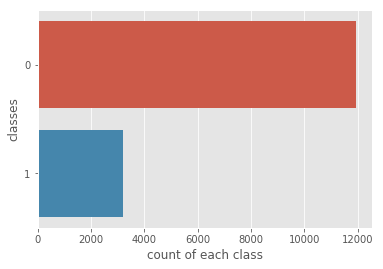

In [5]:
#Print class freq. through pandas 
print(df_stress.groupby('stress').size()) 
#some imports to plot 
%matplotlib inline
plt.style.use('ggplot')

#Visualize Class Counts
y = df_stress.iloc[:,-1]
sns.countplot(y=y ,data=df_stress) 
plt.xlabel("count of each class")
plt.ylabel("classes")
plt.show() # imbalanced target values

In [6]:
from sklearn.utils import resample

#Down-sample Majority Class
#1) Separate majority and minority classes
df_majority = df_stress[y==0] 
df_minority = df_stress[y==1]
 
#2) Downsample majority class -> number of minority class
df_majority_downsampled = resample(df_majority, 
                                   replace=False,
                                   n_samples=3212,     # number of samples into the minority class (change it accordingly to your dataset)
                                   random_state=123)  # reproducible results
 
#3) Combine minority class with downsampled majority class
df_stress = pd.concat([df_majority_downsampled, df_minority])

#4) Display new class counts
df_stress['stress'].value_counts() 

1    3212
0    3212
Name: stress, dtype: int64

## FEATURE SELECTION

### CORRELATION OF NUMERICAL FEATURES

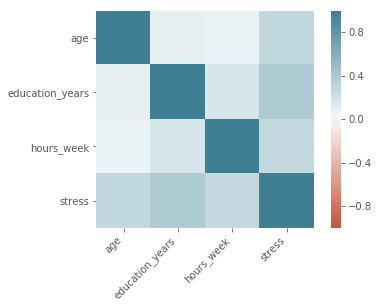

In [7]:
# Heatmap for integer values
corr = df_stress.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

#### CORRELATION WITH THE TARGET

Race has 12836 values that are NaN but there is a big difference between the number of Black race values and Asian-Pac-Islander race ones. Question : is it right to fill with the mode, as for the other features.
Maybe race variable is not even correlated with the dependent variable stress. Let's see!


Wrapper and Embedded methods give more accurate results than the Filter method, but as they are computationally expensive, these method are suited when you have lesser features (~20). Of course, it is not our case.


 I realized what I’m actually looking for is the correlation between the features and the stress’s type — but that’s a problem, as the features are all categorical, and correlation isn’t defined in that case.
 
 One common option to handle this scenario is by first using one-hot encoding, and break each possible option of each categorical feature to 0-or-1 features. This will then allow the use of correlation, but it can easily become too complex to analyse. For example, one-hot encoding converts the 9 categorical features of the data-set to a 96-features data-set, and when plotting the correlation table as a heat-map, we get something like a mess.
 
 But what about a pair of a continuous feature and a categorical feature? 

In [8]:
'''
Cramér’s V. It is based on a nominal variation of Pearson’s Chi-Square Test, 
and comes built-in with some great benefits:
 
1-Similarly to correlation, the output is in the range of [0,1],where 0 means no association and 1 is full association. 
(Unlike correlation, there are no negative values, as there’s no such thing as a negative association. 
Either there is, or there isn’t)

2-Like correlation, Cramer’s V is symmetrical — it is insensitive to swapping x and y

'''

def cramers_v(x, y):
    ''' Parameters
    ----------
    x : list / NumPy ndarray / Pandas Series
        A sequence of categorical measurements
    y : list / NumPy ndarray / Pandas Series
        A sequence of categorical measurements
    '''
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [9]:
#Correlation between categorical race feature and target stress
cramers_v(df_stress['race'], df_stress['stress'])

0.1917258606621651

Since the correlation is very low we can drop the column

## MISSING DATA

### CATEGORICAL FEATURES

In [10]:
# Categorical dataset
cat_df_stress = df_stress.select_dtypes(include=['object']).copy()

In [11]:
# Number of NaN values
print(cat_df_stress.isnull().values.sum())

6352


In [12]:
cat_df_stress.head()

,workclass,education,marital_status,occupation,relationship,race,sex,country,permit
11198,Private,Assoc-voc,Never-married,Other-service,Not-in-family,NaN,Female,United-States,D
1016,Private,HS-grad,Divorced,Other-service,Not-in-family,NaN,Female,United-States,B
6146,Private,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,NaN,Male,United-States,D
3818,Private,HS-grad,Never-married,Adm-clerical,Not-in-family,NaN,Female,United-States,B
6573,Private,Bachelors,Never-married,Adm-clerical,Unmarried,Black,Female,United-States,M


In [13]:
#Null values
print(cat_df_stress.isnull().sum())

workclass          317
education            0
marital_status       0
occupation         319
relationship         0
race              5584
sex                  0
country            132
permit               0
dtype: int64


In [14]:
#Distribution of values for workclass feature
print(cat_df_stress['workclass'].value_counts())

Private             4369
Local-gov            475
Self-emp-not-inc     457
Self-emp-inc         313
State-gov            269
Federal-gov          220
Never-worked           2
Without-pay            2
Name: workclass, dtype: int64


Text(0.5, 0, 'Workclass')

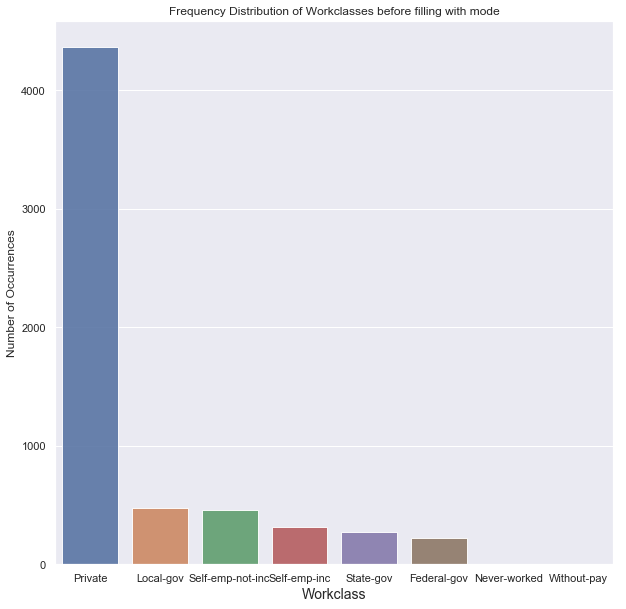

In [15]:
#Show the recurrencies of the categories in workclass feature 
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
carrier_count = cat_df_stress['workclass'].value_counts()
sns.set(style="darkgrid")
sns.barplot(carrier_count.index, carrier_count.values, alpha=0.9)
plt.title('Frequency Distribution of Workclasses before filling with mode')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Workclass', fontsize=14)

In [16]:
#Distribution of values for occupation feature
print(cat_df_stress['occupation'].value_counts())

Prof-specialty       1147
Exec-managerial      1084
Adm-clerical          773
Other-service         707
Craft-repair          653
Sales                 538
Machine-op-inspct     317
Handlers-cleaners     254
Tech-support          214
Transport-moving      156
Protective-serv       121
Farming-fishing       114
Priv-house-serv        24
Armed-Forces            3
Name: occupation, dtype: int64


In [17]:
#Distribution of values for race feature
print(cat_df_stress['race'].value_counts())

Black                 540
Asian-Pac-Islander    200
Other                  53
Amer-Indian-Eskimo     47
Name: race, dtype: int64


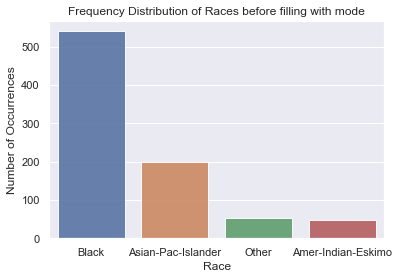

In [18]:
#Show the recurrencies of the categories in race feature 
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
carrier_count = cat_df_stress['race'].value_counts()
sns.set(style="darkgrid")
sns.barplot(carrier_count.index, carrier_count.values, alpha=0.9)
plt.title('Frequency Distribution of Races before filling with mode')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Race', fontsize=12)
plt.show()

In [19]:
#Distribution of values for race feature
print(cat_df_stress['country'].value_counts())

United-States                 5785
Mexico                          98
Philippines                     48
Germany                         33
Canada                          27
India                           23
Poland                          18
Japan                           18
El-Salvador                     17
Cuba                            17
Jamaica                         17
England                         16
Italy                           15
Puerto-Rico                     13
Columbia                        13
Taiwan                          12
Nicaragua                       10
China                           10
Vietnam                          9
Dominican-Republic               9
France                           9
South                            9
Peru                             7
Thailand                         6
Greece                           6
Guatemala                        5
Portugal                         5
Haiti                            5
Scotland            

There is a way to calculate the correlation coefficient without one-hot encoding the category variable. Cramers V statistic is one method for calculating the correlation of categorical variables

In [20]:
#Save target column
target = df_stress['stress']
age = df_stress['age']
education_years = df_stress['education_years']
hours_week = df_stress['hours_week']

In [21]:
#  Mode imputation for those null values
df_stress['workclass'] = cat_df_stress['workclass'].fillna(cat_df_stress['workclass'].value_counts().index[0])
df_stress['occupation'] = cat_df_stress['occupation'].fillna(cat_df_stress['occupation'].value_counts().index[0])
#df_stress['race'] = cat_df_stress['race'].fillna(cat_df_stress['race'].value_counts().index[0])
df_stress['country'] = cat_df_stress['country'].fillna(cat_df_stress['country'].value_counts().index[0])

In [22]:
#Drop race column
'''NB: this column is almost empty and can be drop '''
df_stress = df_stress.drop(columns=['race'])

In [23]:
#No null values in df
print(df_stress.isnull().values.sum())

0


In [24]:
#See that stress column is lost
df_stress.head()

,age,workclass,education,education_years,marital_status,occupation,relationship,sex,hours_week,country,permit,stress
11198,24,Private,Assoc-voc,11,Never-married,Other-service,Not-in-family,Female,40,United-States,D,0
1016,37,Private,HS-grad,9,Divorced,Other-service,Not-in-family,Female,60,United-States,B,0
6146,44,Private,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Male,40,United-States,D,0
3818,31,Private,HS-grad,9,Never-married,Adm-clerical,Not-in-family,Female,40,United-States,B,0
6573,44,Private,Bachelors,13,Never-married,Adm-clerical,Unmarried,Female,40,United-States,M,0


In [25]:
#Assignment
df_stress["stress"] = target
df_stress["age"] = age
df_stress["education_years"] = education_years
df_stress["hours_week"] = hours_week

In [26]:
#Stress added
df_stress.head()

,age,workclass,education,education_years,marital_status,occupation,relationship,sex,hours_week,country,permit,stress
11198,24,Private,Assoc-voc,11,Never-married,Other-service,Not-in-family,Female,40,United-States,D,0
1016,37,Private,HS-grad,9,Divorced,Other-service,Not-in-family,Female,60,United-States,B,0
6146,44,Private,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Male,40,United-States,D,0
3818,31,Private,HS-grad,9,Never-married,Adm-clerical,Not-in-family,Female,40,United-States,B,0
6573,44,Private,Bachelors,13,Never-married,Adm-clerical,Unmarried,Female,40,United-States,M,0


Text(0.5, 0, 'Workclass')

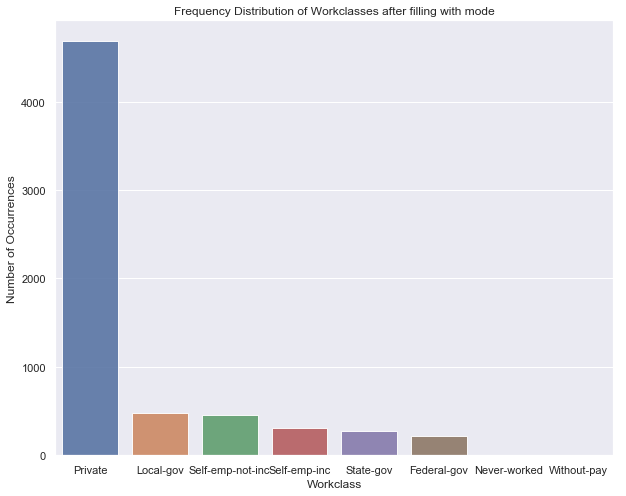

In [27]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
carrier_count = df_stress['workclass'].value_counts()
sns.set(style="darkgrid")
sns.barplot(carrier_count.index, carrier_count.values, alpha=0.9)
plt.title('Frequency Distribution of Workclasses after filling with mode')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Workclass', fontsize=12)


## DATA VISUALIZATION

In [28]:
vis = df_stress.copy()
vis = vis[['age','education_years','hours_week','stress']]
vis.head()

,age,education_years,hours_week,stress
11198,24,11,40,0
1016,37,9,60,0
6146,44,10,40,0
3818,31,9,40,0
6573,44,13,40,0


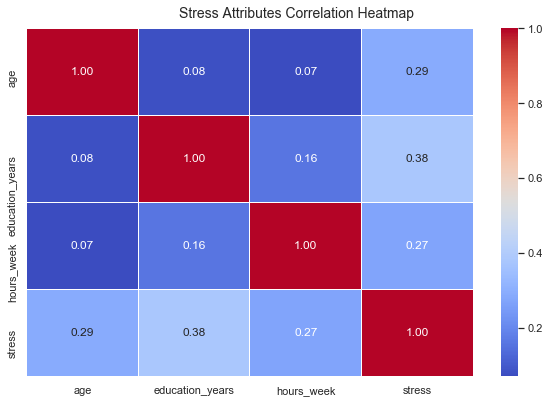

In [29]:
# Correlation Matrix Heatmap
f, ax = plt.subplots(figsize=(10, 6))
corr = vis.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('Stress Attributes Correlation Heatmap', fontsize=14)

/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


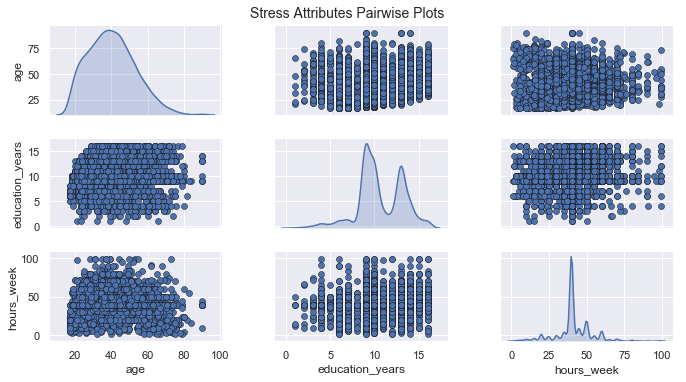

In [30]:
# Pair-wise Scatter Plots

pp = sns.pairplot(vis.drop(columns='stress'), size=1.8, aspect=1.8,
                  plot_kws=dict(edgecolor="k", linewidth=0.5),
                  diag_kind="kde", diag_kws=dict(shade=True))

fig = pp.fig 
fig.subplots_adjust(top=0.93, wspace=0.3)
t = fig.suptitle('Stress Attributes Pairwise Plots', fontsize=14)

Based on the above plot, you can see that scatter plots are also a decent way of observing potential relationships or patterns in two-dimensions for data attributes. In our case there is no correlation.

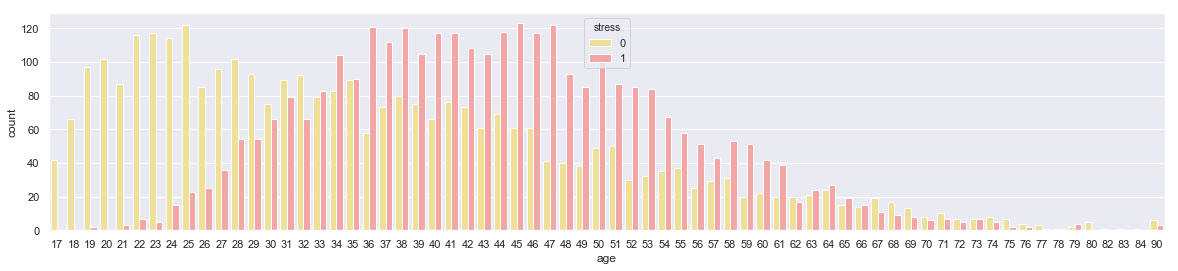

In [31]:
# Multi-bar Plot
plt.figure(figsize=(20,4))
cp = sns.countplot(x="age", hue="stress", data=vis, 
                   palette={0: "#FFE888", 1: "#FF9999"})
plt.show()

In the plot above you can see that middle-age people are more stressed than the youngest.

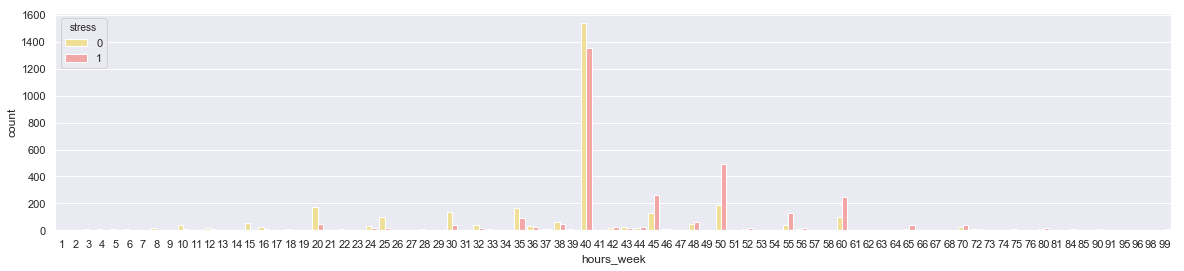

In [32]:
# Multi-bar Plot
plt.figure(figsize=(20,4))
cp = sns.countplot(x="hours_week", hue="stress", data=vis, 
                   palette={0: "#FFE888", 1: "#FF9999"})
plt.show()

/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


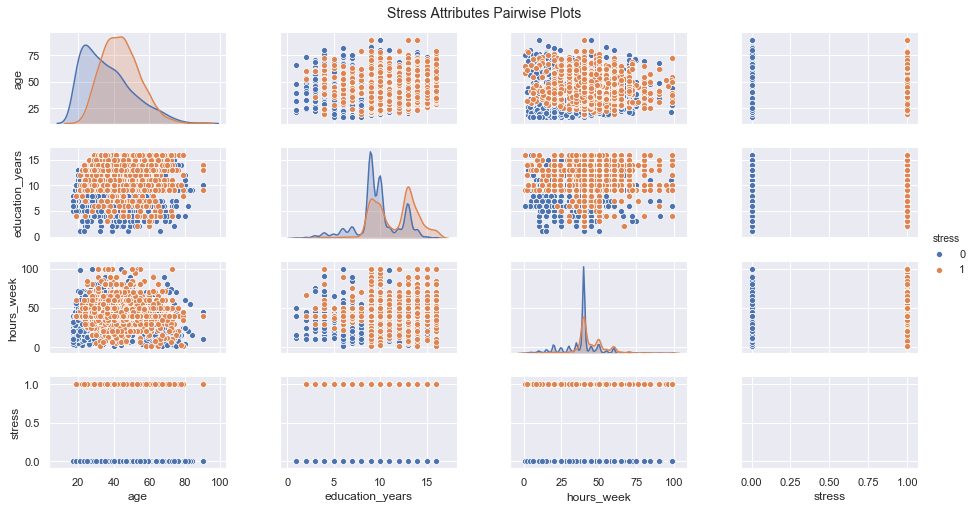

In [33]:
# Scatter Plot with Hue for visualizing data in 3-D

pp = sns.pairplot(vis, hue='stress', size=1.8, aspect=1.8)
fig = pp.fig 
fig.subplots_adjust(top=0.93, wspace=0.3)
t = fig.suptitle('Stress Attributes Pairwise Plots', fontsize=14)

Text(0.5, 0, 'Hours_week')

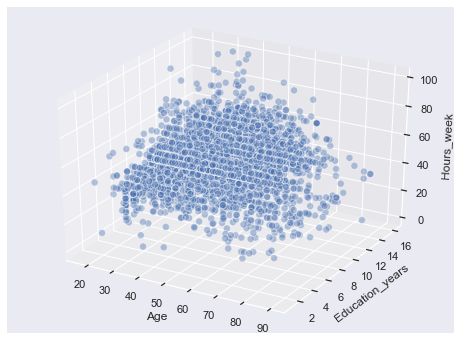

In [34]:
# Visualizing 3-D numeric data with Scatter Plots
from mpl_toolkits.mplot3d import Axes3D
# length, breadth and depth
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

xs = vis['age']
ys = vis['education_years']
zs = vis['hours_week']
ax.scatter(xs, ys, zs, s=50, alpha=0.4, edgecolors='w')

ax.set_xlabel('Age')
ax.set_ylabel('Education_years')
ax.set_zlabel('Hours_week')

Text(0.5, 0, 'Hours_week')

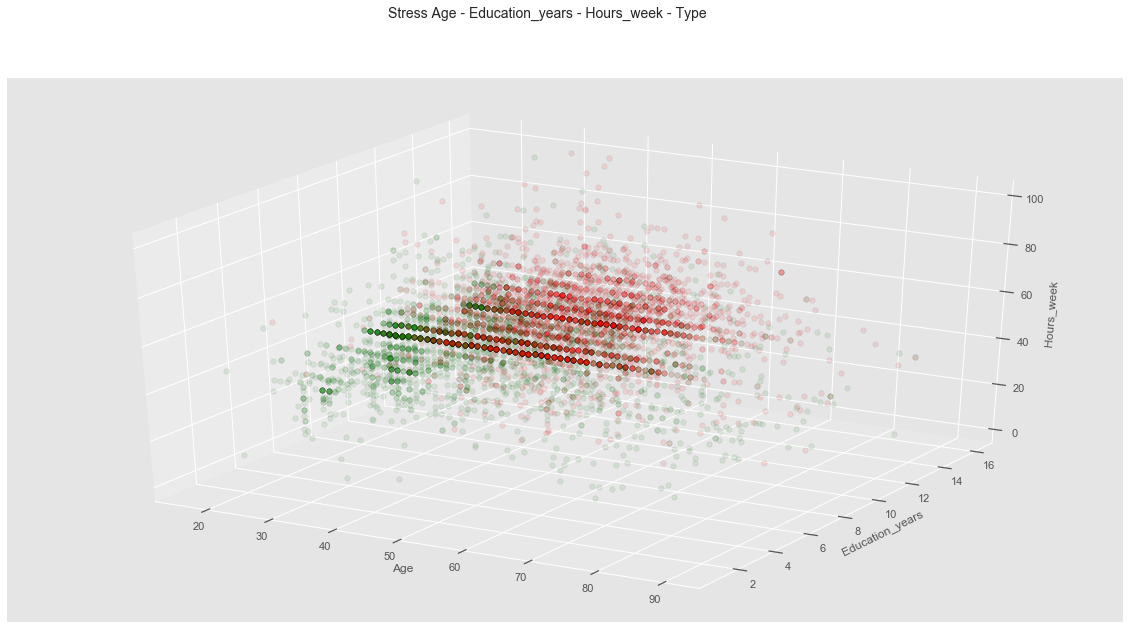

In [51]:
# Visualizing 4-D mix data using scatter plots
# leveraging the concepts of hue and depth
fig = plt.figure(figsize=(20, 10))
t = fig.suptitle('Stress Age - Education_years - Hours_week - Type', fontsize=14)
ax = fig.add_subplot(111, projection='3d')

xs = list(vis['age'])
ys = list(vis['education_years'])
zs = list(vis['hours_week'])
data_points = [(x, y, z) for x, y, z in zip(xs, ys, zs)]
colors = ['green' if wt == 0 else 'red' for wt in list(vis['stress'])]

for data, color in zip(data_points, colors):
    x, y, z = data
    ax.scatter(x, y, z, alpha=0.1, c=color, edgecolors='none', s=30)

ax.set_xlabel('Age')
ax.set_ylabel('Education_years')
ax.set_zlabel('Hours_week')

Text(0.5, 1.05, 'Stress Age - Education Years - Hours - Type')

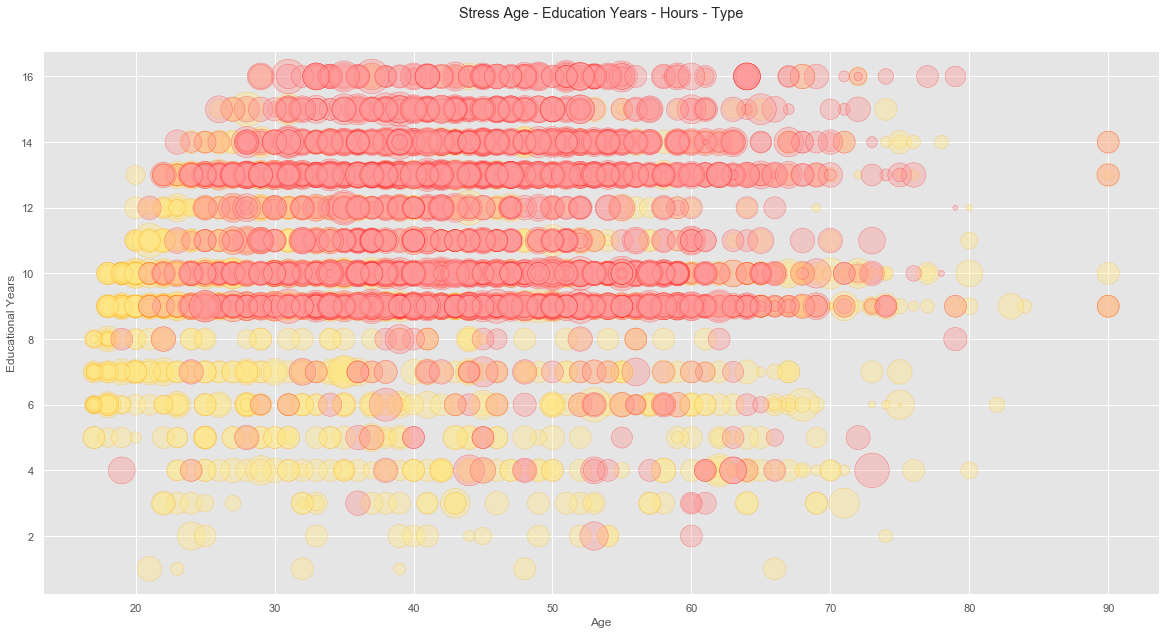

In [50]:
# Visualizing 4-D mix data using bubble plots
# leveraging the concepts of hue and size
plt.figure(figsize=(20,10))
size = vis['hours_week']*12
fill_colors = ['#FF9999' if wt==1 else '#FFE888' for wt in list(vis['stress'])]
edge_colors = ['red' if wt==1 else 'orange' for wt in list(vis['stress'])]

plt.scatter(vis['age'], vis['education_years'], s=size, 
            alpha=0.4, color=fill_colors, edgecolors=edge_colors)

plt.xlabel('Age')
plt.ylabel('Educational Years')
plt.title('Stress Age - Education Years - Hours - Type',y=1.05)

In the figure above : red are depressed people, yellow the healthy people. The ones with much more education years are stressed. Probably because they have responsabilities at work.

### ENCODING CATEGORICAL FEATURES

In [28]:
#One hot encoding for all categorical features
df_stress_onehot = df_stress.copy()
#df_stress_onehot = pd.get_dummies(df_stress_onehot, columns=['race'], prefix = ['race'])
df_stress_onehot = pd.get_dummies(df_stress_onehot, columns=['workclass'], prefix = ['workclass'])
df_stress_onehot = pd.get_dummies(df_stress_onehot, columns=['education'], prefix = ['education'])
df_stress_onehot = pd.get_dummies(df_stress_onehot, columns=['occupation'], prefix = ['occupation'])
df_stress_onehot = pd.get_dummies(df_stress_onehot, columns=['relationship'], prefix = ['relationship'])
df_stress_onehot = pd.get_dummies(df_stress_onehot, columns=['sex'], prefix = ['sex'])
df_stress_onehot = pd.get_dummies(df_stress_onehot, columns=['country'], prefix = ['country'])
df_stress_onehot = pd.get_dummies(df_stress_onehot, columns=['permit'], prefix = ['permit'])
df_stress_onehot = pd.get_dummies(df_stress_onehot, columns=['marital_status'], prefix = ['marital_status'])
df_stress_onehot.head()

,age,education_years,hours_week,stress,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,...,permit_A,permit_B,permit_C,permit_D,permit_M,marital_status_Divorced,marital_status_Married-civ-spouse,marital_status_Never-married,marital_status_Separated,marital_status_Widowed
11198,24,11,40,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0
1016,37,9,60,0,0,0,0,1,0,0,...,0,1,0,0,0,1,0,0,0,0
6146,44,10,40,0,0,0,0,1,0,0,...,0,0,0,1,0,0,1,0,0,0
3818,31,9,40,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
6573,44,13,40,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,1,0,0


In [29]:
#Put stress feature at the end
target = df_stress_onehot['stress']
df_stress_onehot = df_stress_onehot.drop(columns=['stress'])
df_stress_onehot['stress'] = target

In [30]:
df_stress_onehot.head()

,age,education_years,hours_week,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,...,permit_B,permit_C,permit_D,permit_M,marital_status_Divorced,marital_status_Married-civ-spouse,marital_status_Never-married,marital_status_Separated,marital_status_Widowed,stress
11198,24,11,40,0,0,0,1,0,0,0,...,0,0,1,0,0,0,1,0,0,0
1016,37,9,60,0,0,0,1,0,0,0,...,1,0,0,0,1,0,0,0,0,0
6146,44,10,40,0,0,0,1,0,0,0,...,0,0,1,0,0,1,0,0,0,0
3818,31,9,40,0,0,0,1,0,0,0,...,1,0,0,0,0,0,1,0,0,0
6573,44,13,40,0,0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0


In [31]:
df_stress_onehot.shape

(6424, 100)

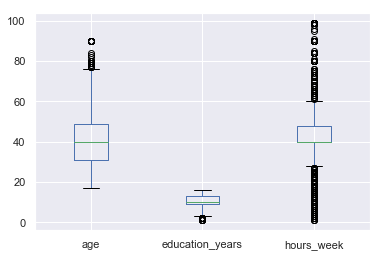

In [32]:
df_stress_onehot[['age','education_years','hours_week']].boxplot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1a1d2cc0>,
      dtype=object)

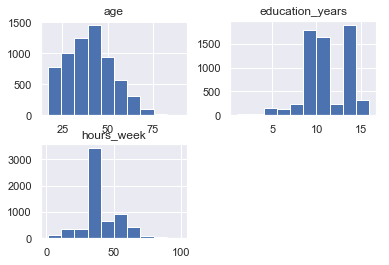

In [33]:
df_stress_onehot[['age','education_years','hours_week']].hist()

# OUTLIER DETECTION AND REMOVING

In [34]:
#Save into a new df
data = pd.DataFrame(df_stress_onehot)
data.columns = df_stress_onehot.columns
data.head()

,age,education_years,hours_week,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,...,permit_B,permit_C,permit_D,permit_M,marital_status_Divorced,marital_status_Married-civ-spouse,marital_status_Never-married,marital_status_Separated,marital_status_Widowed,stress
11198,24,11,40,0,0,0,1,0,0,0,...,0,0,1,0,0,0,1,0,0,0
1016,37,9,60,0,0,0,1,0,0,0,...,1,0,0,0,1,0,0,0,0,0
6146,44,10,40,0,0,0,1,0,0,0,...,0,0,1,0,0,1,0,0,0,0
3818,31,9,40,0,0,0,1,0,0,0,...,1,0,0,0,0,0,1,0,0,0
6573,44,13,40,0,0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0


In [35]:
data.shape

(6424, 100)

The Z-score is the signed number of standard deviations by which the value of an observation or data point is above the mean value of what is being observed or measured.

In [36]:
#Detecting outliers
z = np.abs(ss.zscore(data[['age','education_years','hours_week']]))
print(z)

[[1.26129423 0.12422988 0.1210862 ]
 [0.25431352 0.65549921 1.524477  ]
 [0.28790687 0.26563467 0.1210862 ]
 ...
 [0.87399396 0.90395896 0.7016954 ]
 [0.98504737 0.90395896 0.1210862 ]
 [0.02193335 0.26563467 0.7016954 ]]


In [37]:
#Removing outliers
data = data[(z < 3).all(axis=1)]

In [38]:
#Reduced rows
data.shape

(6278, 100)

# FEATURE SCALING

Before applying any scaling transformations it is very important to split your data into a train set and a test set. If you start scaling before, your training (and test) data might end up scaled around a mean value (see below) that is not actually the mean of the train or test data, and go past the whole reason why you’re scaling in the first place.

In [39]:
# Splitting explanatory variable and target one
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

### TRAIN AND TEST SET

In [40]:
#SPLIT DATA INTO TRAIN AND TEST SET
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size =0.30, #by default is 75%-25%
                                                    #shuffle is set True by default,
                                                    stratify=y,
                                                    random_state= 123) #fix random seed for replicability

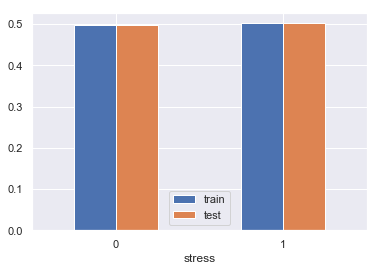

In [41]:
#Well balanced target feature
y_train_dist=y_train.groupby(y_train.iloc[:]).size()/y_train.size
y_test_dist=y_test.groupby(y_test.iloc[:]).size()/y_test.size

train_test_dist = pd.DataFrame({'train': y_train_dist, 'test': y_test_dist})
ax = train_test_dist.plot.bar(rot=0) # rotation of the labels

### STANDARD SCALER

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


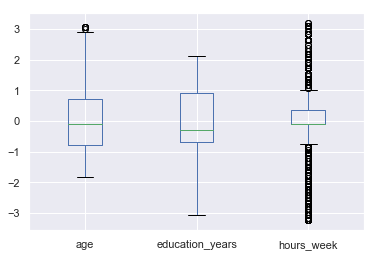

In [42]:
# Scale data
scaler = StandardScaler().fit(X)

scaled_data = scaler.transform(X.astype(float))
scaled_X = pd.DataFrame(scaled_data.astype(float))
scaled_X.columns = X.columns

scaled_data = scaler.transform(X_train.astype(float))
scaled_X_train = pd.DataFrame(scaled_data.astype(float))
scaled_X_train.columns = X_train.columns

scaled_data = scaler.transform(X_test.astype(float))
scaled_X_test = pd.DataFrame(scaled_data.astype(float))
scaled_X_test.columns = X_test.columns

scaled_X[['age','education_years','hours_week']].boxplot()

## K-Nearest Neighbor

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   2

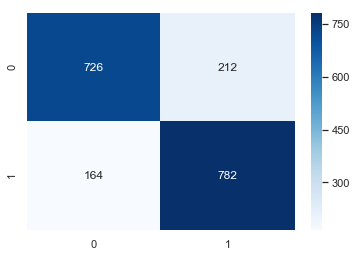

In [41]:
#DEFINE  PARAMETERS GRID
from sklearn.neighbors import KNeighborsClassifier
#Create KNN Classifier
classifier = KNeighborsClassifier()
parameters = {'n_neighbors':np.arange(1,11)}
gs = GridSearchCV(classifier, parameters, cv=3, scoring = 'f1', verbose=50, n_jobs=-1)
#Train the model using the training sets
gs = gs.fit(scaled_X_train, y_train)

#Prediction
print("\n\nBest score: %f using %s" % (gs.best_score_, gs.best_params_))
best_model = gs.best_estimator_
y_pred = best_model.predict(scaled_X_test)

#EVALUATE OUR PREDICTION
print("f1_score: ", metrics.f1_score(y_test, y_pred))
print("accuracy: ", metrics.accuracy_score(y_test, y_pred))

confusion_matrix(y_test, y_pred)

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Blues"); #annot=True to annotate cells fmt: format



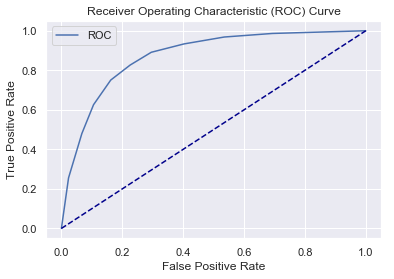

AUC: 0.87


In [42]:
model = KNeighborsClassifier(n_neighbors=gs.best_params_['n_neighbors'])
model.fit(scaled_X_train, y_train)
y_pred = model.predict(scaled_X_test)

y_probs = model.predict_proba(scaled_X_test) #predict_proba gives the probabilities for the target (0 and 1 in your case) 

fpr, tpr, thresholds=metrics.roc_curve(y_test,  y_probs[:,1])

import matplotlib.pyplot as plt
plt.plot(fpr, tpr, label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

auc = metrics.roc_auc_score(y_test, y_probs[:,1])
print('AUC: %.2f' % auc)

## PRINCIPAL COMPONENT ANALYSIS

In [43]:
#PCA fit
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(scaled_X)
df_pca = pd.DataFrame(pca.transform(scaled_X))

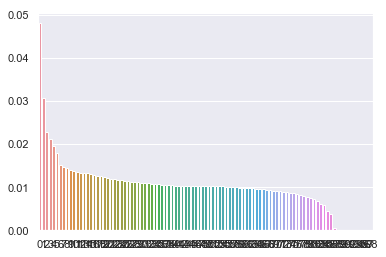

In [44]:
explained_variance=pd.DataFrame(pca.explained_variance_ratio_)
%matplotlib inline
import seaborn as sns
ax = sns.barplot( data=explained_variance.transpose())

In [45]:
pd.DataFrame(pca.components_,columns=X.columns)

,age,education_years,hours_week,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,...,permit_A,permit_B,permit_C,permit_D,permit_M,marital_status_Divorced,marital_status_Married-civ-spouse,marital_status_Never-married,marital_status_Separated,marital_status_Widowed
0,-1.858624e-01,-0.140154,-1.937949e-01,-0.024234,-0.019873,0.012343,0.121844,-0.105312,-0.076695,-0.013677,...,0.004852,0.000288,0.017977,-0.010170,-0.012903,0.140303,-0.379078,0.264045,0.078210,0.077451
1,-1.107088e-01,-0.458863,-4.329606e-02,-0.081790,-0.175030,0.009808,0.238138,-0.065169,-0.026075,-0.119457,...,0.002051,0.014000,0.015596,-0.023884,-0.007817,-0.098264,0.033659,0.046133,0.013856,-0.037441
2,3.462853e-01,-0.213856,-1.224840e-02,0.051202,0.056849,-0.035448,-0.117527,0.022871,0.087025,0.004349,...,0.002929,0.000138,0.002358,-0.003630,-0.001723,0.179314,0.140122,-0.426144,0.114845,0.214265
3,-8.915152e-02,0.067342,-5.930084e-02,-0.037060,0.010885,0.006443,0.043628,-0.013572,-0.040063,-0.011282,...,-0.014233,0.009664,0.009718,-0.025005,0.019804,-0.170855,0.075770,0.058334,0.016176,-0.051722
4,-1.348016e-01,0.011383,-1.780663e-01,-0.037419,-0.073156,0.002906,0.201095,-0.067418,-0.142966,-0.065458,...,-0.010389,-0.029811,0.051817,-0.002163,-0.009339,-0.267639,0.346176,-0.096566,-0.095881,-0.142668
5,-6.485436e-02,-0.139049,-1.582326e-01,0.100635,0.300812,0.073387,-0.508469,0.076452,0.274692,0.199427,...,-0.021873,-0.008738,0.037286,-0.006706,-0.000278,-0.208215,0.038925,0.120980,-0.005203,-0.010701
6,-7.050933e-02,-0.022107,1.182809e-01,0.196858,-0.123175,-0.044295,-0.236610,0.256338,0.186477,-0.005082,...,-0.016446,0.088951,0.030315,0.017279,-0.123155,-0.001118,-0.012870,0.050824,-0.039704,-0.050253
7,1.425419e-01,-0.034026,-4.771421e-02,-0.179164,-0.224623,0.029295,0.051317,0.161102,0.289273,-0.196268,...,0.165155,-0.123910,-0.021523,-0.081371,0.068388,-0.149314,0.008733,0.035773,-0.091661,0.262922
8,-8.823408e-02,-0.028051,1.474978e-01,-0.067380,0.092912,-0.033795,-0.084522,0.032008,0.099588,-0.024114,...,-0.111481,0.066983,-0.033416,-0.059534,0.135926,-0.091856,0.027949,0.126433,-0.116422,-0.108467
9,9.019593e-02,-0.021231,-3.022477e-02,0.138536,0.084014,-0.074145,0.027527,-0.090744,-0.079497,-0.093478,...,0.136957,0.376446,0.096915,-0.416240,-0.195307,-0.067955,0.025095,0.047719,-0.233575,0.167693


In [46]:
X_pca = pd.DataFrame(data = pca.transform(scaled_X))

X_train_pca = pd.DataFrame(data = pca.transform(scaled_X_train))

X_test_pca = pd.DataFrame(data = pca.transform(scaled_X_test))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    

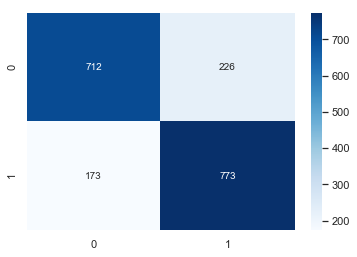

In [47]:
#DEFINE  PARAMETERS GRID
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
classifier = KNeighborsClassifier()
parameters = {'n_neighbors':np.arange(1,11)}
from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(classifier, parameters, cv=3, scoring = 'f1', verbose=50, n_jobs=-1)
gs = gs.fit(X_train_pca.iloc[:,:2], y_train)

#Prediction
print("\n\nBest score: %f using %s" % (gs.best_score_, gs.best_params_))
best_model = gs.best_estimator_
y_pred = best_model.predict(X_test_pca.iloc[:,:2])

print("f1_score: ", metrics.f1_score(y_test, y_pred))
print("accuracy: ", metrics.accuracy_score(y_test, y_pred))

from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Blues"); #annot=True to annotate cells fmt: format




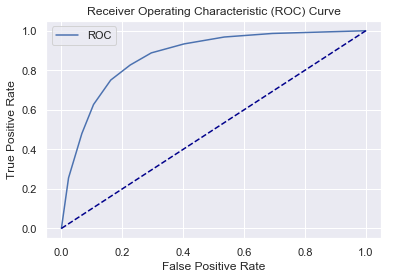

AUC: 0.87


In [48]:
model = KNeighborsClassifier(n_neighbors=gs.best_params_['n_neighbors'])
model.fit(X_train_pca, y_train)
y_pred = model.predict(X_test_pca)

y_probs = model.predict_proba(X_test_pca) #predict_proba gives the probabilities for the target (0 and 1 in your case) 

fpr, tpr, thresholds=metrics.roc_curve(y_test,  y_probs[:,1])

import matplotlib.pyplot as plt
plt.plot(fpr, tpr, label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

auc = metrics.roc_auc_score(y_test, y_probs[:,1])
print('AUC: %.2f' % auc)

# Logistic Regression Model

In [49]:
#DEFINE YOUR CLASSIFIER and THE PARAMETERS GRID
import numpy as np
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
parameters = {"C":[1e-4,1e-3,1e-2,1e-1,1,10]}

In [50]:
#DEFINE YOUR GRIDSEARCH 
'''
GS perfoms an exhaustive search over specified parameter values for an estimator.
GS uses a Stratified K-Folds cross-validator
(The folds are made by preserving the percentage of samples for each class.)
If refit=True the model is retrained on the whole training set with the best found params
'''
gs = GridSearchCV(classifier, parameters, cv=3, scoring = 'f1', verbose=50, n_jobs=-1, refit=True)

In [51]:
#TRAIN YOUR CLASSIFIER
gs = gs.fit(scaled_X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0905s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of  18 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   6 out of  18 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   7 out of  18 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   8 out of  18 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  12 out of  18 | elapsed:    0.7s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  14 out of  18 | elapsed:    0.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | el

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [52]:
#summarize the results of your GRIDSEARCH
print('***GRIDSEARCH RESULTS***')

print("Best score: %f using %s" % (gs.best_score_, gs.best_params_))
means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
params = gs.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

***GRIDSEARCH RESULTS***
Best score: 0.822018 using {'C': 0.01}
0.808965 (0.007556) with: {'C': 0.0001}
0.821009 (0.005770) with: {'C': 0.001}
0.822018 (0.006465) with: {'C': 0.01}
0.820661 (0.009022) with: {'C': 0.1}
0.819538 (0.008723) with: {'C': 1}
0.819531 (0.009239) with: {'C': 10}


In [53]:
#TEST ON YOUR TEST SET 
best_model = gs.best_estimator_
y_pred = best_model.predict(scaled_X_test)
#This is your prediction on the TEST SET
y_pred

array([1, 0, 0, ..., 1, 0, 0])

In [54]:
#EVALUATE YOUR PREDICTION (on the y_test that you left aside)
print('***RESULTS ON TEST SET***')
print("f1_score: ", f1_score(y_test, y_pred))

***RESULTS ON TEST SET***
f1_score:  0.8278350515463917


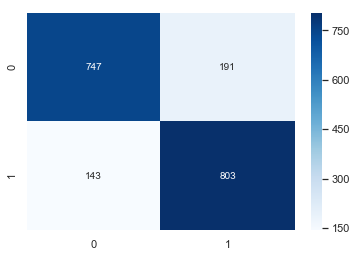

In [55]:
# Plot confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Blues"); #annot=True to annotate cells fmt: format



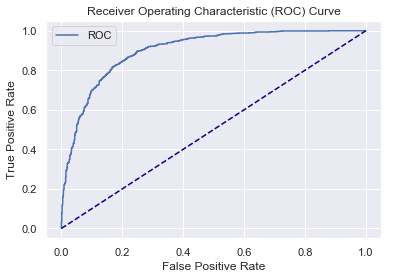

AUC: 0.90


In [56]:

model = LogisticRegression(C=gs.best_params_['C'],solver='lbfgs')
model.fit(scaled_X_train, y_train)
y_pred = model.predict(scaled_X_test)

y_probs = model.predict_proba(scaled_X_test) #predict_proba gives the probabilities for the target (0 and 1 in your case) 

fpr, tpr, thresholds=metrics.roc_curve(y_test,  y_probs[:,1])


plt.plot(fpr, tpr, label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

auc = metrics.roc_auc_score(y_test, y_probs[:,1])
print('AUC: %.2f' % auc)

# DECISION TREE

In [57]:
#DEFINE YOUR CLASSIFIER and THE PARAMETERS GRID
from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier()
parameters = {'criterion': ['entropy','gini'],  # parameters is a dictionary
              'max_depth': [3,4,5],
              'min_samples_split': [5,10],
              'min_samples_leaf': [2]}

# criterion : "gini", "entropy"
# max_depth : The maximum depth of the tree.
# min_samples_split : The minimum number of samples required to split an internal node:
# min_samples_leaf : The minimum number of samples required to be at a leaf node. 

y_pred

array([1, 0, 0, ..., 1, 0, 0])

In [58]:
#DEFINE YOUR GRIDSEARCH : understand which are the best parameters
'''
GS perfoms an exhaustive search over specified parameter values for an estimator.
GS uses a Stratified K-Folds cross-validator
(The folds are made by preserving the percentage of samples for each class.)
If refit=True the model is retrained on the whole training set with the best found params
'''
gs = GridSearchCV(classifier, parameters, cv=3, scoring = 'f1', verbose=50, n_jobs=-1, refit=True)

#TRAIN YOUR CLASSIFIER
gs = gs.fit(scaled_X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0512s.) Setting batch_size=6.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   7 out of  36 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   8 out of  36 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  14 out of  36 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  20 out of  36 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  26 out of  36 | elapsed:    0.3s remaining:    0.1s
[Pa

In [59]:
#summarize the results of your GRIDSEARCH
print('***GRIDSEARCH RESULTS***')

print("Best score: %f using %s" % (gs.best_score_, gs.best_params_)) # in terms of F1 score
means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
params = gs.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

***GRIDSEARCH RESULTS***
Best score: 0.814154 using {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10}
0.795679 (0.017648) with: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 5}
0.795679 (0.017648) with: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 10}
0.809318 (0.010337) with: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 5}
0.809318 (0.010337) with: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 10}
0.812453 (0.010805) with: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5}
0.812453 (0.010805) with: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10}
0.809157 (0.011113) with: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 5}
0.809157 (0.011113) with: {'criterion': 'gini', 'max_depth': 3, 

In [60]:
#TEST ON YOUR TEST SET 
best_model = gs.best_estimator_
y_pred = best_model.predict(scaled_X_test)
y_pred

array([1, 1, 0, ..., 1, 0, 0])

In [61]:
#EVALUATE YOUR PREDICTION (on the y_test that you left aside)
print('***RESULTS ON TEST SET***')
print("f1_score: ", metrics.f1_score(y_test, y_pred))

***RESULTS ON TEST SET***
f1_score:  0.8176623376623378


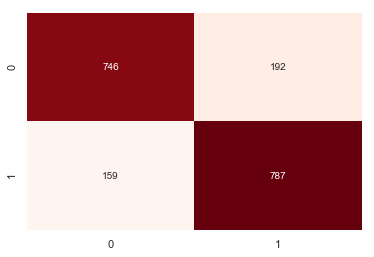

In [62]:
# Plot confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Reds", cbar=False);

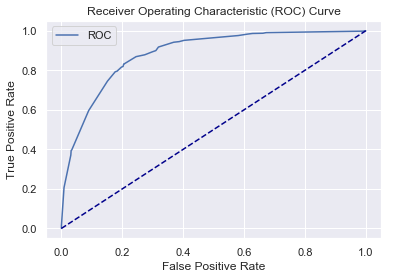

AUC: 0.89


In [63]:
model = DecisionTreeClassifier(criterion=gs.best_params_['criterion'], max_depth=gs.best_params_['max_depth'], min_samples_leaf=gs.best_params_['min_samples_leaf'], min_samples_split=gs.best_params_['min_samples_split'])
model.fit(scaled_X_train, y_train)
y_pred = model.predict(scaled_X_test)

y_probs = model.predict_proba(scaled_X_test) #predict_proba gives the probabilities for the target (0 and 1 in your case) 

fpr, tpr, thresholds=metrics.roc_curve(y_test,  y_probs[:,1])

import matplotlib.pyplot as plt
plt.plot(fpr, tpr, label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

auc = metrics.roc_auc_score(y_test, y_probs[:,1])
print('AUC: %.2f' % auc)

# Multi-layer Perceptron

In [64]:
'''Multi-layer Perceptron classifier'''
from sklearn.neural_network import MLPClassifier


classifier = MLPClassifier()
parameters = {"hidden_layer_sizes":[(5, 2),(10,8,5),(100,20)],  "max_iter": [100,200], "alpha": [0.00001,0.001,0.1]}
#hidden_layer_sizes : The ith element represents the number of neurons in the ith hidden layer.

In [65]:
gs = GridSearchCV(classifier, parameters, cv=3, scoring = 'f1', verbose=50, n_jobs=-1, refit=True)
gs = gs.fit(scaled_X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   1

/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [66]:
#summarize the results of your GRIDSEARCH
print('***GRIDSEARCH RESULTS***')

print("Best score: %f using %s" % (gs.best_score_, gs.best_params_))
means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
params = gs.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

***GRIDSEARCH RESULTS***
Best score: 0.816918 using {'alpha': 1e-05, 'hidden_layer_sizes': (5, 2), 'max_iter': 100}
0.816918 (0.011651) with: {'alpha': 1e-05, 'hidden_layer_sizes': (5, 2), 'max_iter': 100}
0.803546 (0.006058) with: {'alpha': 1e-05, 'hidden_layer_sizes': (5, 2), 'max_iter': 200}
0.804853 (0.004043) with: {'alpha': 1e-05, 'hidden_layer_sizes': (10, 8, 5), 'max_iter': 100}
0.796243 (0.012884) with: {'alpha': 1e-05, 'hidden_layer_sizes': (10, 8, 5), 'max_iter': 200}
0.790567 (0.014271) with: {'alpha': 1e-05, 'hidden_layer_sizes': (100, 20), 'max_iter': 100}
0.780421 (0.009476) with: {'alpha': 1e-05, 'hidden_layer_sizes': (100, 20), 'max_iter': 200}
0.811338 (0.011536) with: {'alpha': 0.001, 'hidden_layer_sizes': (5, 2), 'max_iter': 100}
0.801133 (0.007141) with: {'alpha': 0.001, 'hidden_layer_sizes': (5, 2), 'max_iter': 200}
0.811601 (0.002107) with: {'alpha': 0.001, 'hidden_layer_sizes': (10, 8, 5), 'max_iter': 100}
0.797993 (0.007151) with: {'alpha': 0.001, 'hidden_layer

In [67]:
#TEST ON YOUR TEST SET 
best_model = gs.best_estimator_
y_pred = best_model.predict(scaled_X_test)
#This is your prediction on the TEST SET
y_pred

array([1, 0, 0, ..., 1, 0, 0])

In [68]:
#EVALUATE YOUR PREDICTION (on the y_test that you left aside)
print('***RESULTS ON TEST SET***')
print("f1_score: ", f1_score(y_test, y_pred))

***RESULTS ON TEST SET***
f1_score:  0.8215209518882566


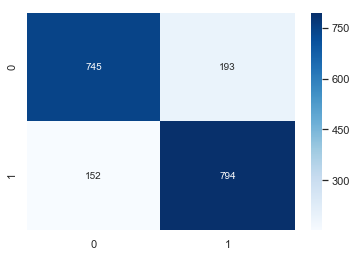

In [69]:
# Plot confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Blues"); #annot=True to annotate cells fmt: format



/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


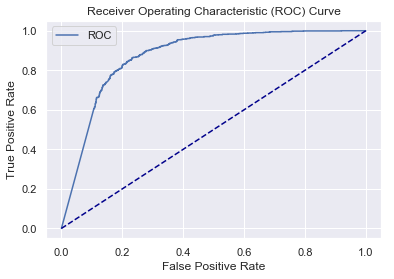

AUC: 0.88


In [70]:
model=MLPClassifier(hidden_layer_sizes=gs.best_params_['hidden_layer_sizes'], alpha=gs.best_params_['alpha'], max_iter=gs.best_params_['max_iter'])
model.fit(scaled_X_train, y_train)
y_pred = model.predict(scaled_X_test)

y_probs = model.predict_proba(scaled_X_test) #predict_proba gives the probabilities for the target (0 and 1 in your case) 

fpr, tpr, thresholds=metrics.roc_curve(y_test,  y_probs[:,1])

plt.plot(fpr, tpr, label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

auc = metrics.roc_auc_score(y_test, y_probs[:,1])
print('AUC: %.2f' % auc)

# Naive Bayes

In [71]:

from sklearn.naive_bayes import GaussianNB #or alternative NB implementations

model = GaussianNB()

model.fit(scaled_X_train, y_train)
y_pred=model.predict(scaled_X_test)

In [72]:
print('***RESULTS ON TEST SET***')
print("f1_score: ", f1_score(y_test, y_pred))

***RESULTS ON TEST SET***
f1_score:  0.7526970954356847


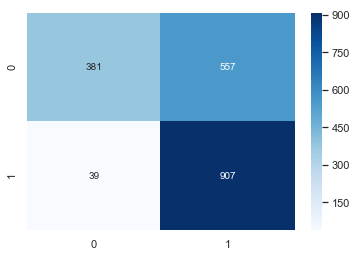

In [73]:
# Plot confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Blues"); #annot=True to annotate cells fmt: format


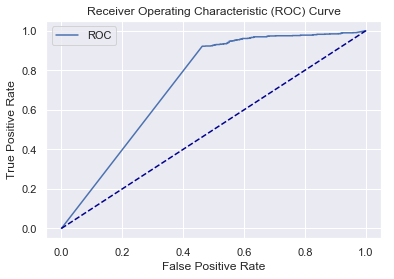

AUC: 0.73


In [74]:
y_probs = model.predict_proba(scaled_X_test) #predict_proba gives the probabilities for the target (0 and 1 in your case) 

fpr, tpr, thresholds=metrics.roc_curve(y_test,  y_probs[:,1])

plt.plot(fpr, tpr, label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

auc = metrics.roc_auc_score(y_test, y_probs[:,1])
print('AUC: %.2f' % auc)

# SUPPORT VECTOR MACHINE

In [75]:
from sklearn.svm import SVC

classifier = SVC()
parameters = {"kernel":['linear'], "C":[0.1,1],"gamma":[1e-4,0.01]}

In [76]:
#DEFINE YOUR GRIDSEARCH 
'''
GS perfoms an exhaustive search over specified parameter values for an estimator.
GS uses a Stratified K-Folds cross-validator
(The folds are made by preserving the percentage of samples for each class.)
If refit=True the model is retrained on the whole training set with the best found params
'''
gs = GridSearchCV(classifier, parameters, cv=3, scoring = 'f1', verbose=50, n_jobs=-1, refit=True)
#TRAIN YOUR CLASSIFIER
gs = gs.fit(scaled_X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done   6 out of  12 | elapsed:    7.9s remaining:    7.9s
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:    9.0s remaining:    6.4s
[Parallel(n_jobs=-1)]: Done   8 out of  12 | elapsed:    9.5s remaining:    4.7s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:   12.7s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:   12.7s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   13.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   13.9s finish

In [77]:
#summarize the results of your GRIDSEARCH
print('***GRIDSEARCH RESULTS***')

print("Best score: %f using %s" % (gs.best_score_, gs.best_params_))
means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
params = gs.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

***GRIDSEARCH RESULTS***
Best score: 0.806323 using {'C': 0.1, 'gamma': 0.0001, 'kernel': 'linear'}
0.806323 (0.005288) with: {'C': 0.1, 'gamma': 0.0001, 'kernel': 'linear'}
0.806323 (0.005288) with: {'C': 0.1, 'gamma': 0.01, 'kernel': 'linear'}
0.806323 (0.005288) with: {'C': 1, 'gamma': 0.0001, 'kernel': 'linear'}
0.806323 (0.005288) with: {'C': 1, 'gamma': 0.01, 'kernel': 'linear'}


In [78]:
#TEST ON YOUR TEST SET 
best_model = gs.best_estimator_
y_pred = best_model.predict(scaled_X_test)
y_pred

array([1, 0, 0, ..., 1, 0, 0])

In [79]:
#EVALUATE YOUR PREDICTION (on the y_test that you left aside)

print('***RESULTS ON TEST SET***')
print("f1_score: ", f1_score(y_test, y_pred))

***RESULTS ON TEST SET***
f1_score:  0.8140020898641588


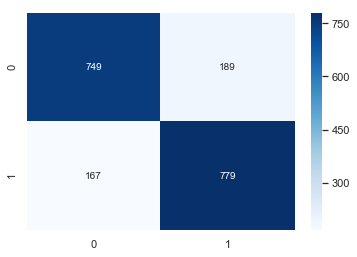

In [80]:
# Plot confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Blues"); #annot=True to annotate cells fmt: format



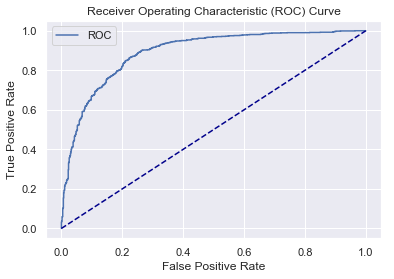

AUC: 0.89


In [81]:

model = SVC(C=0.1, gamma=0.0001, kernel='linear',probability=True)

model.fit(scaled_X_train, y_train)
y_pred = model.predict(scaled_X_test)

y_probs = model.predict_proba(scaled_X_test) #predict_proba gives the probabilities for the target (0 and 1 in your case) 

fpr, tpr, thresholds=metrics.roc_curve(y_test,  y_probs[:,1])

import matplotlib.pyplot as plt
plt.plot(fpr, tpr, label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

auc = metrics.roc_auc_score(y_test, y_probs[:,1])
print('AUC: %.2f' % auc)